Data Preparation

In [4]:
import keras
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

countt=0
fracture = []
nonfrac = []
for dirname, _, filenames in os.walk('/kaggle/input/fracatlas/FracAtlas/images/Fractured'):
    for filename in filenames:
        img_path  = os.path.join(dirname,filename)
        img = image.load_img(img_path, target_size=(224, 224,3))
        x_img = image.img_to_array(img)
        x_img = np.expand_dims(x_img, axis=0)
        x_imp = preprocess_input(x_img)
        fracture.append(x_img[0])
        
n = len(fracture)
n

717

In [5]:
countt = 0
for dirname, _, filenames in os.walk('/kaggle/input/fracatlas/FracAtlas/images/Non_fractured'):
    for filename in filenames:
        img_path  = os.path.join(dirname,filename)
        try:
            img = image.load_img(img_path, target_size=(224, 224,3))
            x_img = image.img_to_array(img)
            x_img = np.expand_dims(x_img, axis=0)
            x_imp = preprocess_input(x_img)
            if x_img is not None:
                nonfrac.append(x_img[0])
                countt+=1
                if countt==n:
                    break
        except:
            print(f"Error processing image {img_path}")

Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004347.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004297.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004148.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004177.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004291.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004290.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004288.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004263.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004029.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fractured/IMG0004189.jpg
Error processing image /kaggle/input/fracatlas/FracAtlas/images/Non_fr

In [6]:
fracture_array = np.array(fracture)
nonfrac_array = np.array(nonfrac)

combined_array = np.concatenate((fracture_array, nonfrac_array), axis=0)

print(combined_array.shape)

(1434, 224, 224, 3)


In [7]:
sz1 = n
sz2 = n

array1 = np.array([1])
array2 = np.array([0])

repeated_array1 = np.tile(array1, (sz1, 1))
repeated_array2 = np.tile(array2, (sz2, 1))

result_array = np.concatenate((repeated_array1, repeated_array2), axis=0)

print(result_array.shape)

(1434, 1)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_array, result_array, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1147, 224, 224, 3)
X_test shape: (287, 224, 224, 3)
y_train shape: (1147, 1)
y_test shape: (287, 1)


In [9]:
# look how classification of images in dataset
fr = 0
nf = 0
for y in y_train:
    if y[0]==1:
        fr += 1
    elif y[0]==0:
        nf += 1
        
print(f"fractured images = {fr}\nnon fractured images = {nf}\ntotal images = {fr+nf}")

fractured images = 573
non fractured images = 574
total images = 1147


(224, 224, 3)


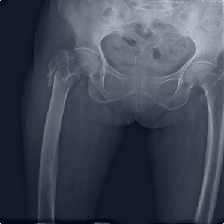

In [10]:
print(X_train[0].shape)
keras.utils.array_to_img(X_train[0])

Data Preprocessing

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(zoom_range=0.1, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
 horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator()

Labels: [array([1]), array([1]), array([1]), array([1]), array([1])]


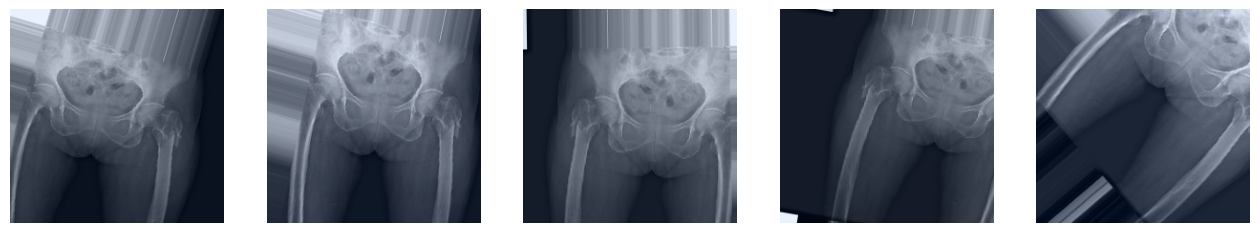

In [14]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_id = 0
cat_generator = train_datagen.flow(X_train[img_id:img_id+1],
                                   y_train[img_id:img_id+1],
                                   batch_size=1)

cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])

# Convert arrays to images
cat_images = [image.array_to_img(img_array[0]) for img_array, _ in cat]

# Display images
for i in range(5):
    ax[i].imshow(cat_images[i])
    ax[i].axis('off')  # Turn off axis
plt.show()

In [16]:
batch=10
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch)
val_generator = val_datagen.flow(X_test, y_test, batch_size=batch,shuffle=False )

In [18]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# Load the pre-trained VGG model without the top (fully connected) layers
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Create a new model with the VGG base model's input and output
vgg = Model(inputs=base_model.input, outputs=base_model.output)

# Load weights from the H5 file
vgg.load_weights('/kaggle/input/vgg16-weights-tf-keras/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [19]:
from keras import optimizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

x = vgg.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=x)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(learning_rate=0.00001), metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 134,264,641 (512.18 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
len(X_train)

1147

Model Training

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

modelCheckpoint = ModelCheckpoint(
    'vgg_1.keras',
    monitor="accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)
from keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor="accuracy",
    min_delta=0.0001,
    patience=0,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [26]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[earlyStopping, modelCheckpoint]
)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 845s 7s/step - accuracy: 0.4914 - loss: 1.1619 - val_accuracy: 0.5017 - val_loss: 1.4555
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 857s 7s/step - accuracy: 0.4998 - loss: 1.0412 - val_accuracy: 0.5017 - val_loss: 1.3030
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [27]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 849s 7s/step - accuracy: 0.5335 - loss: 1.0466 - val_accuracy: 0.5017 - val_loss: 1.3294
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 861s 7s/step - accuracy: 0.5052 - loss: 1.0500 - val_accuracy: 0.5017 - val_loss: 1.2200
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 846s 7s/step - accuracy: 0.5249 - loss: 0.8948 - val_accuracy: 0.5017 - val_loss: 1.1457
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 870s 7s/step - accuracy: 0.5038 - loss: 0.8903 - val_accuracy: 0.5017 - val_loss: 1.0516
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 852s 7s/step - accuracy: 0.4998 - loss: 0.7526 - val_accuracy: 0.5017 - val_loss: 0.9885
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 864s 7s/step - accuracy: 0.5130 - loss: 0.7934 - val_accuracy: 0.5017 - val_loss: 0.9481
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 860s 7s/step - accuracy: 0.5127 - loss: 0.7548 - val_accuracy: 0.5017 - val_loss: 0.9108
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 846s 7s/step - accuracy: 0.5032 - loss: 0.7786 - val_accu

In [28]:
model.save("vgg1.weight.h5");

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5036 - loss: 0.8813
Test Loss: 0.8250605463981628
Test Accuracy: 0.5017421841621399


In [30]:
img_path = '/kaggle/input/fracatlas/FracAtlas/images/Fractured/IMG0000019.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x_img = image.img_to_array(img)
x_img = np.expand_dims(x_img, axis=0)
x_imp = preprocess_input(x_img)

features = model.predict(x_img)

features

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


array([[1.]], dtype=float32)

In [36]:
features = model.predict(X_test[0:20])
features

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [37]:
y_test[0:20]

array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]])